In [22]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
doplot = true

true

## Files and directories

In [23]:
figdir = "./figures/"
outputdir = "../product/"
datadir = "./data/"
datafile = joinpath(datadir, "Biddulphia sinensis-1995-2020.csv")
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

"./data/Biddulphia sinensis-1995-2020.csv"

## Prepare mask
### Interpolation grid

In [15]:
longrid = -2.:0.1:10.
latgrid = 51.:0.1:56.

51.0:0.1:56.0

### Download file

In [16]:
bathname = "./data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[16]:5


### Read bathymetry

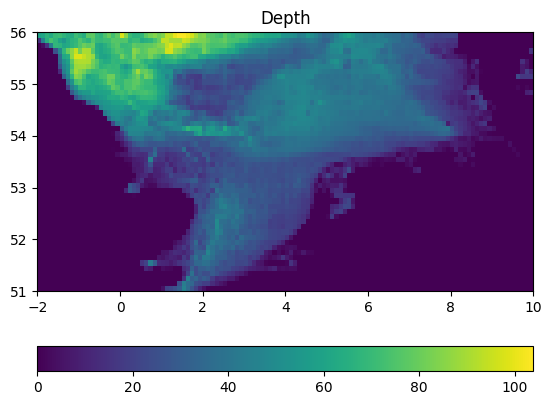

size(b) = (121, 51)


In [17]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    show()
end

### Metrics

In [18]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Computation

In [26]:
speciesname = get_species_name(basename(datafile))
speciesslug = get_species_slug(basename(datafile))
@info("Working on $(speciesname)")
        
# Data reading
dates, lons, lats, occurs = read_data_phyto(datafile);

# Conversion of coordinates
# We have to go from `EPSG:32361` to `WGS84`.         
lon, lat = transform_coords(lons, lats)

data_presence = occurs .== 1;
data_absence = .!(data_presence);

┌ Info: Working on Biddulphia sinensis
└ @ Main In[26]:3


### Compute heatmap
We compute: 
1. the heatmap using all the observation (presence or absence),
2. the heatmap using only the presence observations,
3. the heatmap only the absence observations.

The first provives an indication of the sampling effort: high values in an area means a lot of measurements have been made in that area. This could be used to adapt the inflation vector, which is filled with 1's by default.      
To to so, the heatmap has to be interpolated at the location of the observations.

In [27]:
inflation = ones(length(lon));
@time dens1, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon, lat), inflation, 0.2);
@time dens2, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_presence], lat[data_presence]), inflation[data_presence], 0.2);
@time dens3, LHM, LCV, LSCV = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon[data_absence], lat[data_absence]), inflation[data_absence], 0.2);

┌ Warning: Data array size (25777,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /srv/julia/pkg/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 39.478074 seconds (58.46 M allocations: 3.925 GiB, 5.94% gc time)
  4.888443 seconds (621.36 k allocations: 4.755 GiB, 6.20% gc time)


┌ Warning: Data array size (18820,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /srv/julia/pkg/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


  1.637636 seconds (698.74 k allocations: 1.013 GiB, 3.65% gc time)


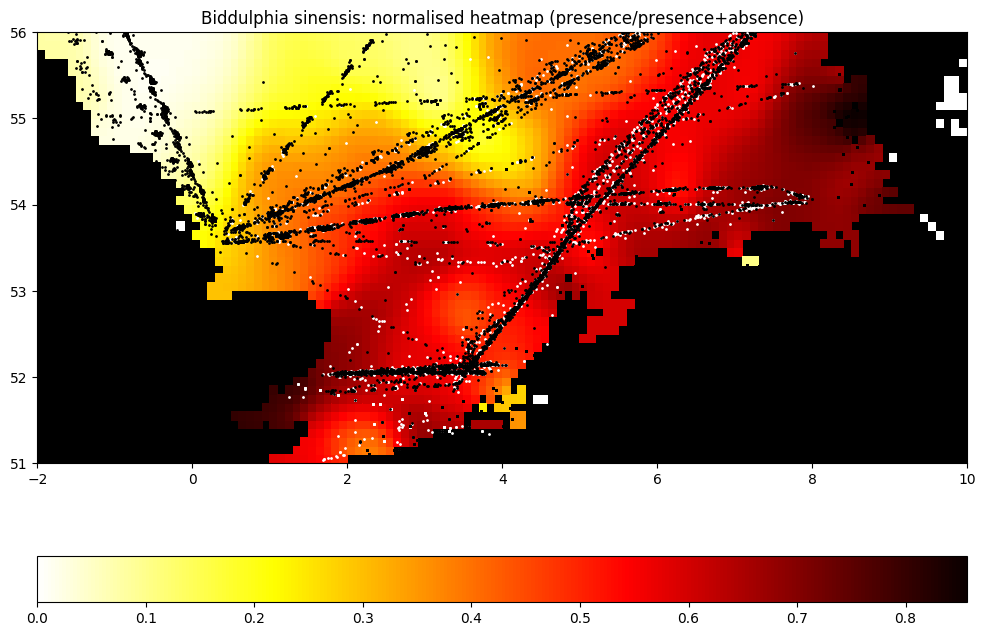

In [28]:
if doplot
    """
    plot_heatmap(longrid, latgrid, dens1, lon[data_presence], lat[data_presence],
        "$(speciesname): heatmap with 'presence' data points", joinpath(figdir, "$(speciesname)_heatmap_presence.png"))
    plot_heatmap(longrid, latgrid, dens2, lon[data_absence], lat[data_absence],
        "$(speciesname): heatmap with 'absence' data points", joinpath(figdir, "$(speciesname)_heatmap_absence.png"))
    plot_heatmap(longrid, latgrid, dens3, lon, lat,
        "$(speciesname): heatmap with all data points", joinpath(figdir, "$(speciesname)_heatmap_all.png"))
    """
    plot_heatmap(longrid, latgrid, dens2 ./ (dens2 .+ dens3), lon, lat, occurs,
        "$(speciesname): normalised heatmap (presence/presence+absence)")
    pcolormesh(longrid, latgrid, mask', cmap=PyPlot.cm.binary_r)
end

# Write in netCDF
create_nc_results(joinpath(outputdir, "$(speciesname)_heatmap.nc"), 
    longrid, latgrid, dens2 ./ (dens2 .+ dens3), speciesname);